# Medical Abstract Segmentation (ALL ABSTRACTS)

## Imports

In [8]:
import re # regex
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras 
from keras import layers
from keras.utils import plot_model


from sklearn.preprocessing import OneHotEncoder, LabelEncoder 
from sklearn.metrics import (
    accuracy_score, top_k_accuracy_score, f1_score, matthews_corrcoef, 
    classification_report, precision_recall_fscore_support, 
    confusion_matrix, ConfusionMatrixDisplay
)

In [9]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


In [10]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [11]:
!unzip /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip

Archive:  /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip
  inflating: train.txt               


In [12]:
# For this model we'll use the 20k dataset no preprocessing
# we use numbers replaced with at sign

dataset_dir = "/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/"

## Exploration

free text -> csv

In [13]:
def get_raw_data(filepath):
    with open(filepath) as f:
        # return f.readlines()
        return f.read().split("\n\n") # splitting as list only at instances of double new line (end of abstract)

In [14]:
# Load the data
train_data = get_raw_data(dataset_dir + 'train.txt')
dev_data = get_raw_data(dataset_dir + 'dev.txt')
test_data = get_raw_data(dataset_dir + 'test.txt')

In [15]:
len(train_data), len(dev_data), len(test_data)

(190655, 2501, 2501)

In [16]:
train_data[:2] # visualizing

["###24491034\nBACKGROUND\tThe emergence of HIV as a chronic condition means that people living with HIV are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .\nBACKGROUND\tThis paper describes the design and evaluation of Positive Outlook , an online program aiming to enhance the self-management skills of gay men living with HIV .\nMETHODS\tThis study is designed as a randomised controlled trial in which men living with HIV in Australia will be assigned to either an intervention group or usual care control group .\nMETHODS\tThe intervention group will participate in the online group program ` Positive Outlook ' .\nMETHODS\tThe program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with HIV in daily life .\nMETHODS\tParticipants will access the program for a minimum of @ minutes per 

# Extracting breast cancer abstracts only

In [17]:
def get_breast_cancer_abstracts(data_list, all_words):

  # bca : breast cancer abstracts
  bca_list = []

  for abstract in data_list:
    for w in all_words:
      if w.lower() in abstract.lower():
        bca_list.append(abstract)
        continue # we only need to find one instance of any of the words above

  return bca_list

In [18]:
all_words = ["breast cancer", "breast oncology", "breast carcinoma", "breast maligna", "metastatic breast",
             "breast neoplas", "ductal carcinoma", "DCIS", "mammary carcinoma",
             "mammary cancer", "malignant breast", "invasive ductal breast",
             "invasive lobular", "triple negative", "HER2"]

# bca : breast cancer abstracts
train_bca = get_breast_cancer_abstracts(train_data, all_words)
dev_bca = get_breast_cancer_abstracts(dev_data, all_words)
test_bca = get_breast_cancer_abstracts(test_data, all_words)


In [19]:
len(train_bca)

3866

In [20]:
len(dev_bca)

69

In [21]:
len(test_bca)

55

In [22]:
# total
total_num_samples = len(train_bca) + len(dev_bca) + len(test_bca)
num_training = 0.7*total_num_samples
num_dev = 0.2*total_num_samples
num_test = 0.1*total_num_samples

num_training, num_dev, num_test

(2793.0, 798.0, 399.0)

In [23]:
all_data = train_bca + dev_bca + test_bca
len(all_data)

3990

In [24]:
final_train_data = all_data[:2793]
final_dev_data = all_data[2793: (2800+798)]
final_test_data = all_data[(2800+798):]

len(final_train_data), len(final_dev_data), len(final_test_data)

(2793, 805, 392)

In [25]:
final_train_data = "\n\n".join(final_train_data)
final_dev_data = "\n\n".join(final_dev_data)
final_test_data = "\n\n".join(final_test_data)

In [26]:
with open('final_train_data.txt', 'w') as f:
    f.write(final_train_data)
with open('final_dev_data.txt', 'w') as f:
    f.write(final_dev_data)
with open('final_test_data.txt', 'w') as f:
    f.write(final_test_data)

In summary, this is the outline of an abstract:

* Abstract Start -> ###< abstract_id >\n
* Abstract Line -> < TARGET >\t< abstract_text >
* Abstract End -> \n

ref: https://www.kaggle.com/code/matthewjansen/nlp-medical-abstract-segmentation 

## Raw Data Preprocessing

In [27]:
def get_raw_data(filepath):
    with open(filepath) as f:
        return f.readlines()

In [28]:
def preprocess_raw_data(filepath):
    raw_data = get_raw_data(filepath)
    abstract_data = ''
    abstract_samples = []
    abstract_id = 0

    
    for line in raw_data:
        # ###[abstract_id]\n
        if line.startswith('###'): # check if current line is an abstract start (line -> ###[abstract_id]\n)
            abstract_id = int(line.replace('###', '').replace('\n', '')) # get abstract id
            abstract_data = ''

        elif line.isspace(): # check if current line is an abstract end (line -> '\n')
            abstract_data_split = abstract_data.splitlines()
            
            for abstract_line_number, abstract_line in enumerate(abstract_data_split):
                line_data = {} # store lines in dictionary
                target_text_split = abstract_line.split("\t") # split target label from text 
                
                line_data["abstract_id"] = abstract_id # get abstract id
                line_data["line_id"] = f'{abstract_id}_{abstract_line_number}_{len(abstract_data_split)}' # create id for each line
                line_data["abstract_text"] = target_text_split[1] # get target text and lower it
                line_data["line_number"] = abstract_line_number # get line number in the abstract
                line_data["total_lines"] = len(abstract_data_split) # get total count for abstract lines (counter starts at 1)
                line_data['current_line'] = f'{abstract_line_number}_{len(abstract_data_split)}' # embed line_number & total_lines into one feature 
                line_data["target"] = target_text_split[0] # get target label
                
                abstract_samples.append(line_data) # append line data to abstract samples list

        else: # if the above conditions aren't fulfilled, the line is a abstract text line (line -> [TARGET]\t[abstract_text])
            abstract_data += line

    return abstract_samples

**Note: we need to do MORE preprocessing to extract abstracts that ONLY specify breast cancer**

In [29]:
%%time
# Get train data from file and preprocess it
train_samples = preprocess_raw_data("/content/final_train_data.txt")

CPU times: user 156 ms, sys: 28.9 ms, total: 185 ms
Wall time: 218 ms


In [30]:
%%time
# Get dev/validation data from file and preprocess it
val_samples = preprocess_raw_data("/content/final_dev_data.txt")

CPU times: user 42.4 ms, sys: 6.83 ms, total: 49.2 ms
Wall time: 50.9 ms


In [31]:
%%time
# Get test data from file and preprocess it
test_samples = preprocess_raw_data("/content/final_test_data.txt")

CPU times: user 24.9 ms, sys: 803 µs, total: 25.7 ms
Wall time: 39 ms


In [32]:
train_samples[:1] # train_samples is a list of dicts

[{'abstract_id': 16308853,
  'line_id': '16308853_0_13',
  'abstract_text': 'Use of blue dye alone as a marker for sentinel lymph node ( SLN ) biopsy is effective , but combining it with isotope marking can improve the success rate .',
  'line_number': 0,
  'total_lines': 13,
  'current_line': '0_13',
  'target': 'BACKGROUND'}]

**Objective, methods, results, etc REMAINS separated**

### To Pandas DF

In [33]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [34]:
train_df.head()

,abstract_id,line_id,abstract_text,line_number,total_lines,current_line,target
0,16308853,16308853_0_13,Use of blue dye alone as a marker for sentinel...,0,13,0_13,BACKGROUND
1,16308853,16308853_1_13,Use of the isotope adds extra cost and there a...,1,13,1_13,BACKGROUND
2,16308853,16308853_2_13,The two techniques were compared in a randomiz...,2,13,2_13,BACKGROUND
3,16308853,16308853_3_13,Women with early breast cancer ( less than @ c...,3,13,3_13,METHODS
4,16308853,16308853_4_13,Women older than @ years with multicentric can...,4,13,4_13,METHODS


One method: squish all with same abstract ID

In [35]:
# Distribution of labels in training data
train_df.target.value_counts()

RESULTS        12043
METHODS         9742
CONCLUSIONS     5193
BACKGROUND      3135
OBJECTIVE       2437
Name: target, dtype: int64

## Quick Data Analysis

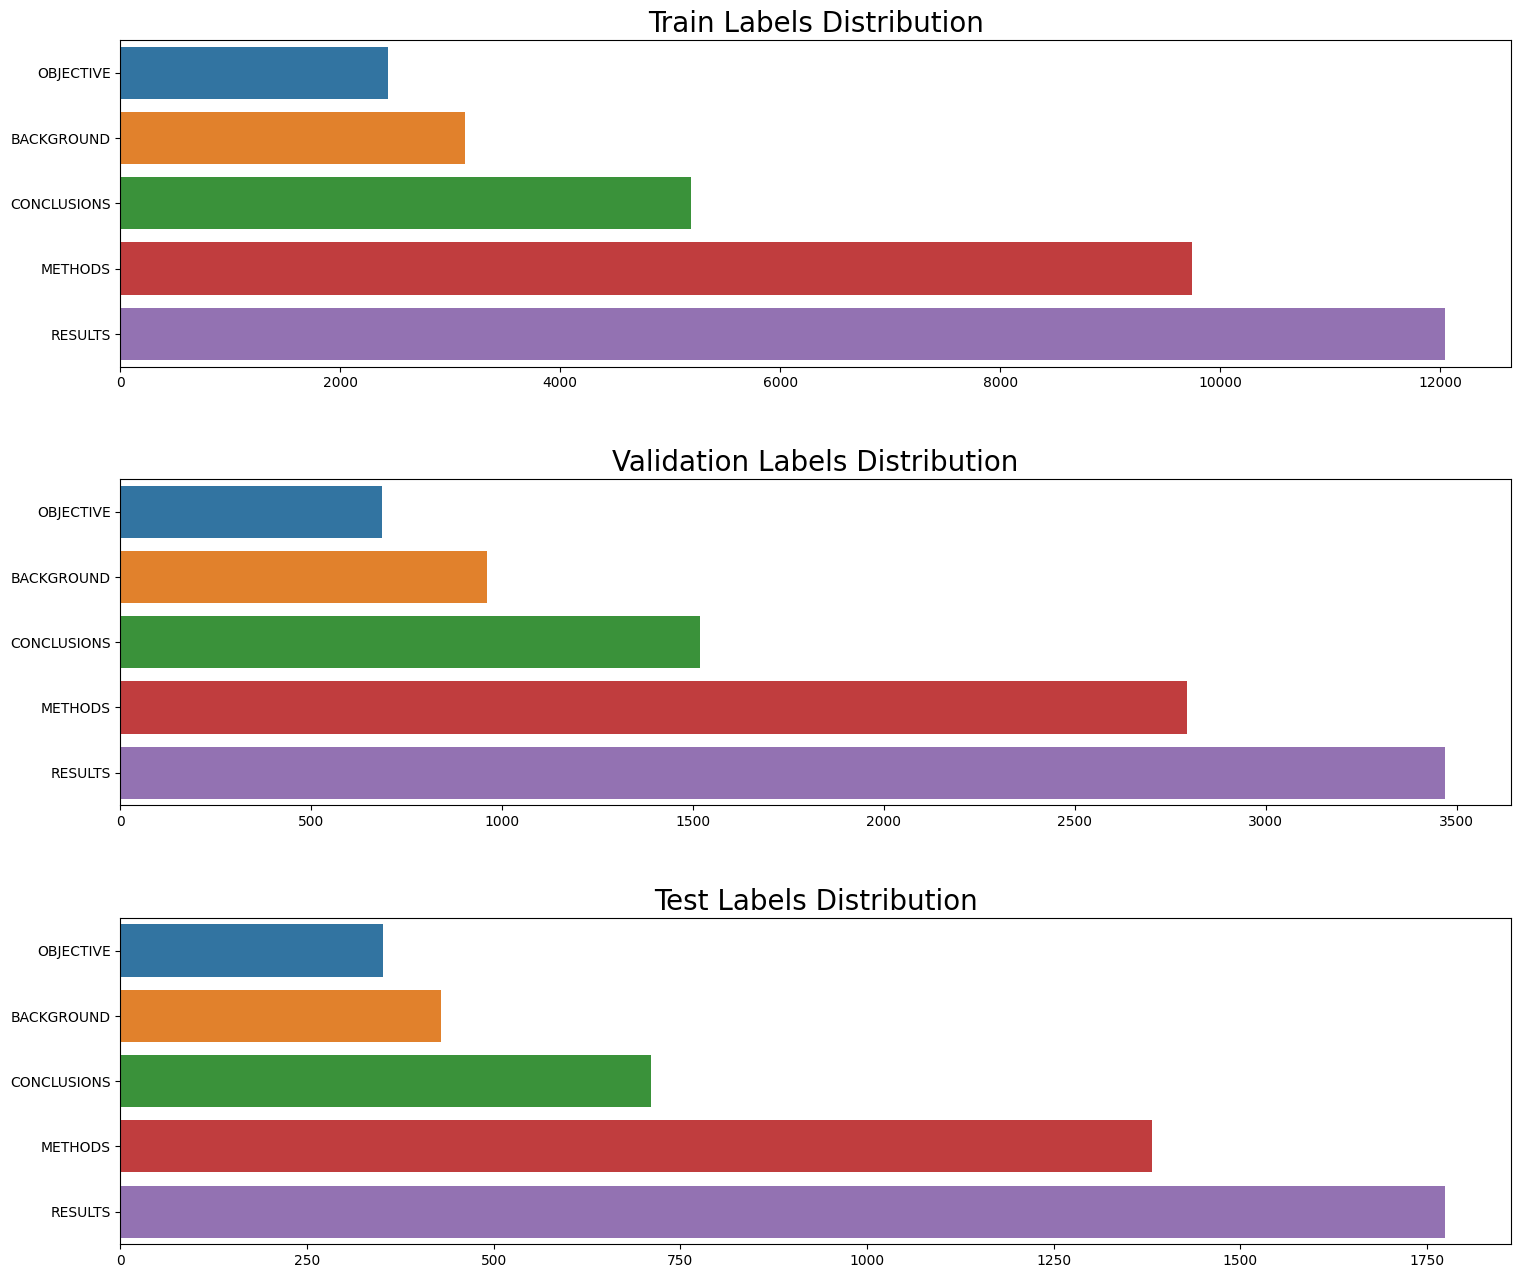

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16, 14))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Plot Train Labels Distribution
ax1.set_title('Train Labels Distribution', fontsize=20)
train_distribution = train_df['target'].value_counts().sort_values()
sns.barplot(x=train_distribution.values,
            y=list(train_distribution.keys()),
            orient="h",
            ax=ax1)

# Plot Validation Labels Distribution
ax2.set_title('Validation Labels Distribution', fontsize=20)
val_distribution = val_df['target'].value_counts().sort_values()
sns.barplot(x=val_distribution.values,
            y=list(val_distribution.keys()),
            orient="h",
            ax=ax2);

# Plot Test Labels Distribution
ax3.set_title('Test Labels Distribution', fontsize=20)
test_distribution = test_df['target'].value_counts().sort_values()
sns.barplot(x=test_distribution.values,
            y=list(test_distribution.keys()),
            orient="h",
            ax=ax3);

# Text Preprocessing

### Sentences as list

In [37]:
# Convert abstract text lines into lists
train_sentences = train_df["abstract_text"].tolist()
val_sentences = val_df["abstract_text"].tolist()
test_sentences = test_df["abstract_text"].tolist()

In [38]:
train_sentences[:2]

['Use of blue dye alone as a marker for sentinel lymph node ( SLN ) biopsy is effective , but combining it with isotope marking can improve the success rate .',
 'Use of the isotope adds extra cost and there are potential radiation hazards .']

In [39]:
train_sentences_count = len(train_sentences)
val_sentences_count = len(val_sentences)
test_sentences_count = len(test_sentences)
total_sentences_count = train_sentences_count + val_sentences_count + test_sentences_count

print(f'Train samples count:\t\t{train_sentences_count}')
print(f'Dev/Validation sample count:\t{val_sentences_count}')
print(f'Test sample count:\t\t{test_sentences_count}')
print(f'Total samples:\t\t\t{total_sentences_count}')

Train samples count:		32550
Dev/Validation sample count:	9427
Test sample count:		4649
Total samples:			46626


### One-hot encoding target vars

In [40]:
one_hot_encoder = OneHotEncoder(sparse_output=False)

In [41]:
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

In [42]:
train_df["target"][:3]

0    BACKGROUND
1    BACKGROUND
2    BACKGROUND
Name: target, dtype: object

In [43]:
train_labels_one_hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Label encode targets

why?

In [44]:
label_encoder = LabelEncoder()

In [45]:
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# inspect label encoded targets
train_labels_encoded

array([0, 0, 0, ..., 4, 1, 1])

In [46]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

print(f'Number of classes: {num_classes}')
print(f'Classes: {class_names}')

Number of classes: 5
Classes: ['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']


## One-hot encode "current lines"

**CHANGE THIS**

In [47]:
line_one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist')

In [48]:
train_df

,abstract_id,line_id,abstract_text,line_number,total_lines,current_line,target
0,16308853,16308853_0_13,Use of blue dye alone as a marker for sentinel...,0,13,0_13,BACKGROUND
1,16308853,16308853_1_13,Use of the isotope adds extra cost and there a...,1,13,1_13,BACKGROUND
2,16308853,16308853_2_13,The two techniques were compared in a randomiz...,2,13,2_13,BACKGROUND
3,16308853,16308853_3_13,Women with early breast cancer ( less than @ c...,3,13,3_13,METHODS
4,16308853,16308853_4_13,Women older than @ years with multicentric can...,4,13,4_13,METHODS
...,...,...,...,...,...,...,...
32545,10721943,10721943_3_8,"For tumours of size @-@ mm , @ % were node neg...",3,8,3_8,RESULTS
32546,10721943,10721943_4_8,The major effects on survival were tumour size...,4,8,4_8,RESULTS
32547,10721943,10721943_5_8,Primary adjuvant therapy had no significant as...,5,8,5_8,RESULTS
32548,10721943,10721943_6_8,The advent of mammography has substantially en...,6,8,6_8,CONCLUSIONS


In [49]:
%%time
train_lines_encoded = line_one_hot_encoder.fit_transform(train_df["current_line"].to_numpy().reshape(-1, 1)).astype(np.float32)
val_lines_encoded = line_one_hot_encoder.transform(val_df["current_line"].to_numpy().reshape(-1, 1)).astype(np.float32)
test_lines_encoded = line_one_hot_encoder.transform(test_df["current_line"].to_numpy().reshape(-1, 1)).astype(np.float32)

CPU times: user 65.8 ms, sys: 136 ms, total: 202 ms
Wall time: 199 ms


## Apply smoothing to current_lines 

why?

In [50]:
def apply_smoothing(line_one_hot, esp=0.01):
    return np.abs(line_one_hot - esp)

def revert_smoothing(line_one_hot_smooth, esp=0.01):
    unsmooth = line_one_hot_smooth
    
    unsmooth[unsmooth>esp] = 1.0
    unsmooth[unsmooth<=esp] = 0.0
    
    return unsmooth

In [51]:
# Only apply smoothing to train lines feature 
train_lines_encoded = apply_smoothing(train_lines_encoded)

In [52]:
train_lines_encoded

array([[0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       ...,
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01]], dtype=float32)

# Dataset input pipeline

In [53]:
def create_pipeline(features, labels, batch_size=32, shuffle=False, cache=False, prefetch=False) -> tf.data.Dataset:
    '''
    Generates an input pipeline using the tf.data API for training and inference.
    
    @params
        - features: (tuple) -> tuple containing the feature data 
        - labels: (tf.Tensor | np.ndarray, default=None) -> target data related to the feature data
        - batch_size: (int) -> size for batched (default=32) 
        - shuffle: (bool) -> condition for data shuffling, data is shuffled when True (default=False)
        - cache: (bool) -> condition for caching data, data is cached in memory when True (default=False)
        - prefetch: (bool) -> condition for prefeching data, data is prefetched when True (default=False)
        
    @returns
        - dataset: (tf.data.Dataset) -> dataset input pipeline used to train a TensorFlow model
    '''
    
    AUTOTUNE = tf.data.AUTOTUNE
    
    # Create dataset with features and labels
    ds = tf.data.Dataset.from_tensor_slices((features, labels))
    
    # Apply shuffling based on condition
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
        
    # Apply batching
    ds = ds.batch(batch_size)
    
    # Apply caching based on condition
    # Note: Do this if the data is small enough to fit in memory!!!
    if cache:
        ds = ds.cache(buffer_size=AUTOTUNE)
    
    # Apply prefetching based on condition
    # Note: This will result in memory trade-offs
    if prefetch:
        ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    # Return the dataset
    return ds

In [54]:
BATCH_SIZE = 32

# Create preprocessed training dataset
train_features = (train_sentences, train_lines_encoded.astype(np.float32)) 
train_labels = train_labels_one_hot.astype(np.float32)

# Create preprocessed train input data pipeline
train_ds = create_pipeline(
    train_features, train_labels, 
    batch_size=BATCH_SIZE, shuffle=True, 
    cache=False, prefetch=True)

In [55]:
# Create preprocessed validation dataset
val_features = (val_sentences, val_lines_encoded.astype(np.float32)) 
val_labels = val_labels_one_hot.astype(np.float32)

# Create preprocessed validation input data pipeline
val_ds = create_pipeline(val_features, val_labels, 
                         batch_size=BATCH_SIZE, shuffle=False, 
                         cache=False, prefetch=True)

In [56]:
# Create preprocessed test dataset
test_features = (test_sentences, test_lines_encoded.astype(np.float32)) 
test_labels = test_labels_one_hot.astype(np.float32)

# Create preprocessed test input data pipeline
test_ds = create_pipeline(test_features, test_labels, 
                          batch_size=BATCH_SIZE, shuffle=False, 
                          cache=False, prefetch=True)

In [57]:
# View string representation of datasets
print('========================================')
print('Train Input Data Pipeline:\n\n', train_ds)
print('========================================')
print('Validation Input Data Pipeline:\n\n', val_ds)
print('========================================')
print('Test Input Data Pipeline:\n\n', test_ds)
print('========================================')

Train Input Data Pipeline:

 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 348), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
Validation Input Data Pipeline:

 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 348), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
Test Input Data Pipeline:

 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 348), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>


In [ ]:
!pip install tensorflow-text

In [59]:
def get_tfhub_model(model_link, model_name, model_trainable=False):
    return hub.KerasLayer(model_link,
                          trainable=model_trainable,
                          name=model_name)

In [60]:
encoder_link = 'https://tfhub.dev/google/universal-sentence-encoder/4'
encoder_name = 'universal_sentence_encoder'
encoder_trainable=False # set trainable to False for inference-only 

encoder = get_tfhub_model(encoder_link, encoder_name, model_trainable=encoder_trainable)

## Model Constructor

In [61]:
class SelfAttentionBlock(layers.Layer):
    
    def __init__(self, units: int, activation='gelu', kernel_initializer='GlorotNormal', **kwargs):
        super(SelfAttentionBlock, self).__init__(**kwargs)
        self.units = units
        self.activation = activation
        self.kernel_initializer = tf.keras.initializers.deserialize(kernel_initializer)
        
        self.query = layers.LSTM(self.units, activation=self.activation, 
                                 kernel_initializer=self.kernel_initializer, 
                                 return_sequences=True, name=f'block_query_lstm')
        
        self.value = layers.LSTM(self.units, activation=self.activation, 
                                 kernel_initializer=self.kernel_initializer, go_backwards=True, 
                                 return_sequences=True, name=f'block_value_lstm')
        
        self.attention = layers.AdditiveAttention(name='block_attention')
        self.average_pooler = layers.GlobalAveragePooling1D(name='block_average_pooler')
        self.query_batch_norm = layers.BatchNormalization(name='block_query_batch_norm')
        self.attention_batch_norm = layers.BatchNormalization(name='block_attention_batch_norm')
        self.residual = layers.Add(name='block_residual')
        
        
    def __call__(self, x):
        # Expand dimensions for LSTMs
        dim_expand_layer = layers.Lambda(lambda embedding: tf.expand_dims(embedding, axis=1), name='block_dim_expand')
        x_expanded = dim_expand_layer(x)
        
        # Generate LSTM sequences
        block_query = self.query(x_expanded)
        block_value = self.value(x_expanded)
        
        # Apply self-attention to LSTM 
        block_attention = self.attention([block_query, block_value])
        
        # Apply GlobalAvgPooling and BatchNorm to ensure output shape is 1D 
        block_query_pooling = self.average_pooler(block_query)
        block_query_batch_norm = self.query_batch_norm(block_query_pooling)
        
        block_attention_pooling = self.average_pooler(block_attention)
        block_attention_batch_norm = self.attention_batch_norm(block_attention_pooling)
        
        # Generate addition residual with processed query and attention
        block_residual = self.residual([block_query_batch_norm, block_attention_batch_norm])
        
        return block_residual

In [62]:
def build_model():
    # Model Inputs
    #------------
    abstract_input = layers.Input(shape=[], dtype=tf.string, name='abstract_text_input')    
    abstract_current_line = layers.Input(shape=(348), dtype=tf.float32, name='abstract_current_line') ### CHANGE: INPUT SHAPE from 460
    
    # Define Layer Initializer
    #------------
    initializer = tf.keras.initializers.GlorotNormal()

    # Text Embedding
    #------------
    abstract_embedding = encoder(abstract_input)
    
    # Self Attention Block Stream
    #------------
    add_attention_block = SelfAttentionBlock(64)(abstract_embedding)
    abstract_dense = layers.Dense(64, activation='gelu', kernel_initializer=initializer)(abstract_embedding)
    attention_residual = layers.Multiply(name='mul_residual')([add_attention_block, abstract_dense])
    
    # Current Line Stream
    #------------
    current_line_dense = layers.Dense(32, activation='gelu', kernel_initializer=initializer)(abstract_current_line)
    current_line_dense = layers.Dropout(0.2)(current_line_dense)

    # Concat Streams
    #------------
    streams_concat = layers.Concatenate()([
        attention_residual,
        current_line_dense
    ])

    # Output Layer
    #------------
    output_layer = layers.Dense(64, activation='gelu', kernel_initializer=initializer)(streams_concat)
    output_layer = layers.Dense(5, activation='softmax', kernel_initializer=initializer)(output_layer)

    return tf.keras.Model(inputs=[abstract_input, 
                                  abstract_current_line], 
                          outputs=[output_layer], name="use_attention_model")

In [63]:
model = build_model()

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [64]:
# View summary of model
model.summary()

Model: "use_attention_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 abstract_text_input (InputLaye  [(None,)]           0           []                               
 r)                                                                                               
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['abstract_text_input[0][0]']    
 rasLayer)                                                                                        
                                                                                                  
 block_dim_expand (Lambda)      (None, 1, 512)       0           ['universal_sentence_encoder[0][0
                                                                 ]']            

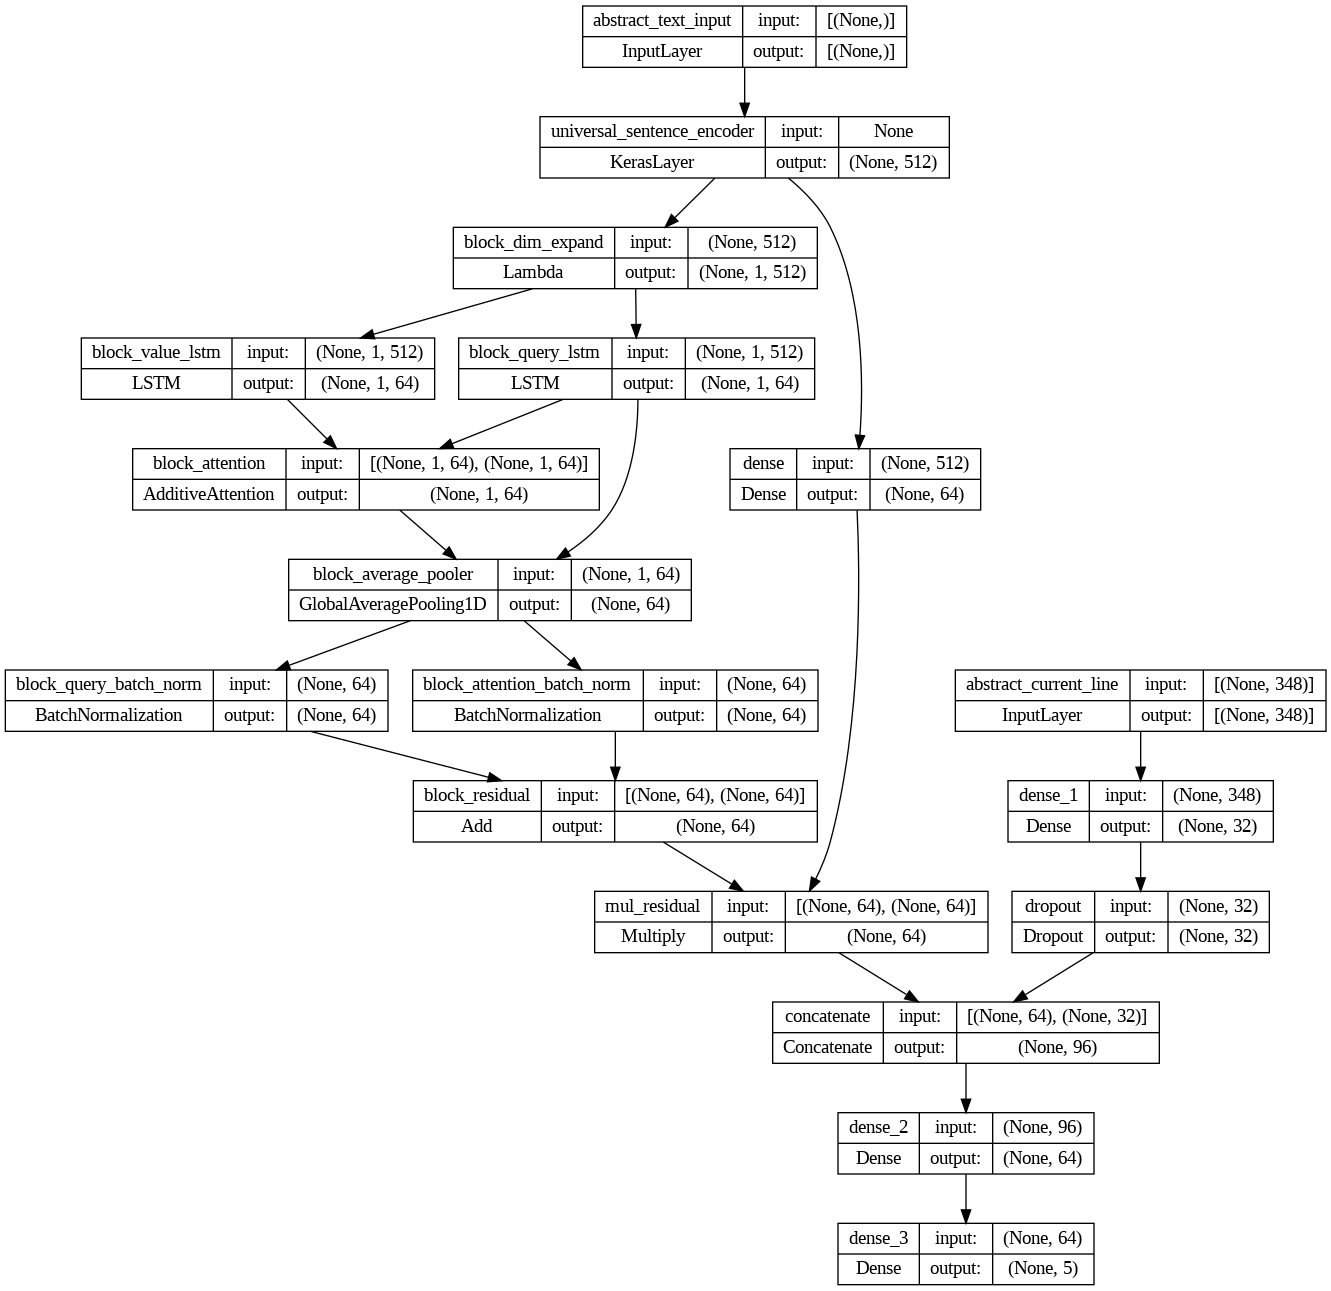

In [65]:
# Explore model visually
plot_model(
    model,
    show_shapes=True,
    expand_nested=True
)

In [66]:
def train_model(model, num_epochs, callbacks_list, tf_train_data, 
                tf_valid_data=None, shuffling=False):
    '''
        Trains a TensorFlow model and returns a dict object containing the model metrics history data. 
        
        @params
        - model: (tf.keras.model) -> model to be trained 
        - num_epochs: (int) -> number of epochs to train the model
        - callbacks_list: (list) -> list containing callback fuctions for model
        - tf_train_data: (tf.data.Dataset) -> dataset for model to be train on 
        - tf_valid_data: (tf.data.Dataset) -> dataset for model to be validated on (default=None)
        - shuffling: (bool) -> condition for data shuffling, data is shuffled when True (default=False)
        
        @returns
        - model_history: (dict) -> dictionary containing loss and metrics values tracked during training
    '''
    
    model_history = {}
    
    if tf_valid_data != None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  validation_data=tf_valid_data,
                                  validation_steps=int(len(tf_valid_data)),
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
        
    if tf_valid_data == None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
    return model_history

In [67]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=4, 
    restore_best_weights=True)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    factor=0.1,
    verbose=1)

EPOCHS = 10
CALLBACKS = [early_stopping_callback, reduce_lr_callback]
METRICS = ['accuracy']

In [68]:
train_sentences_count = len(train_sentences)
val_sentences_count = len(val_sentences)
test_sentences_count = len(test_sentences)
total_sentences_count = train_sentences_count + val_sentences_count + test_sentences_count

In [69]:
tf.random.set_seed(42)

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)

print(f'Training {model.name}.')
print(f'Train on {train_sentences_count} samples, validate on {val_sentences_count} samples.')
print('----------------------------------')

model_history = train_model(
    model, EPOCHS, CALLBACKS, 
    train_ds, val_ds,
    shuffling=False
)

Training use_attention_model.
Train on 32550 samples, validate on 9427 samples.
----------------------------------
Epoch 1/10
1018/1018 [==============================] - 85s 63ms/step - loss: 0.8222 - accuracy: 0.7813 - val_loss: 0.7148 - val_accuracy: 0.8361 - lr: 0.0010
Epoch 2/10
1018/1018 [==============================] - 30s 30ms/step - loss: 0.6597 - accuracy: 0.8655 - val_loss: 0.7012 - val_accuracy: 0.8432 - lr: 0.0010
Epoch 3/10
1018/1018 [==============================] - 28s 28ms/step - loss: 0.6210 - accuracy: 0.8892 - val_loss: 0.7055 - val_accuracy: 0.8406 - lr: 0.0010
Epoch 4/10
1017/1018 [============================>.] - ETA: 0s - loss: 0.5897 - accuracy: 0.9080
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1018/1018 [==============================] - 31s 30ms/step - loss: 0.5897 - accuracy: 0.9080 - val_loss: 0.7136 - val_accuracy: 0.8413 - lr: 0.0010
Epoch 5/10
1018/1018 [==============================] - 29s 28ms/step - loss: 0.5504 

~10 mins

In [70]:
# evaluate the model on the test data to see how it performs
model.evaluate(test_ds)

146/146 [==============================] - 2s 14ms/step - loss: 0.6980 - accuracy: 0.8443


[0.6979709267616272, 0.8442676067352295]

In [71]:
# generate validation probabilities
val_probabilities = model.predict(val_ds, verbose=1)
val_probabilities

295/295 [==============================] - 13s 13ms/step


array([[0.3357102 , 0.02176552, 0.00882819, 0.6257734 , 0.00792271],
       [0.03629778, 0.02338795, 0.88263   , 0.03921541, 0.01846899],
       [0.05392716, 0.02753512, 0.8224062 , 0.04828192, 0.04784952],
       ...,
       [0.01199654, 0.08338389, 0.01832934, 0.02013336, 0.8661569 ],
       [0.02482951, 0.948609  , 0.01557258, 0.00720467, 0.00378436],
       [0.14150529, 0.78897095, 0.01177973, 0.05374729, 0.00399683]],
      dtype=float32)

In [72]:
# generate test probabilities
test_probabilities = model.predict(test_ds, verbose=1)
test_probabilities

146/146 [==============================] - 3s 22ms/step


array([[0.54986936, 0.0283601 , 0.02856773, 0.38908732, 0.00411546],
       [0.66251147, 0.019719  , 0.01170851, 0.2937474 , 0.01231365],
       [0.668872  , 0.01794543, 0.0310232 , 0.26106638, 0.02109295],
       ...,
       [0.01829612, 0.03294207, 0.01097753, 0.05599419, 0.8817901 ],
       [0.07073983, 0.66500926, 0.01252396, 0.02975629, 0.22197066],
       [0.06317834, 0.89144766, 0.01450398, 0.02484994, 0.00602013]],
      dtype=float32)

In [73]:
# generate test predictions with argmax
test_predictions = tf.argmax(test_probabilities, axis=1)
test_predictions

<tf.Tensor: shape=(4649,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 1, 1])>

In [74]:
def plot_training_curves(history):
    
    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])

    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    epochs = range(len(history.history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2)

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss')
    ax1.plot(epochs, val_loss, label='val_loss')
    
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy')
    ax2.plot(epochs, val_accuracy, label='val_accuracy')
    
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.legend();

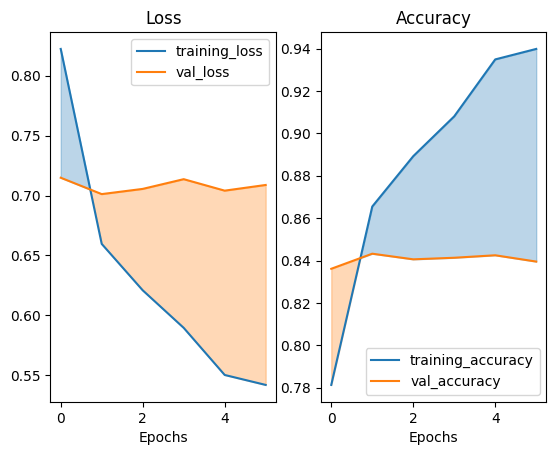

In [75]:
# plot model training history 
plot_training_curves(model_history)

It seems that the model starts overfitting around the second/third epoch since the train loss curve continues to go lower while the validation loss curve remains somewhat constant. However, since the EarlyStopping callback is implemented the model's best weights are saved after the model's training is stopped.

In [76]:
# generate validation predictions with argmax
val_predictions = tf.argmax(val_probabilities, axis=1)
val_predictions

<tf.Tensor: shape=(9427,), dtype=int64, numpy=array([3, 2, 2, ..., 4, 1, 1])>

In [77]:
# Generate validation classification report
print(classification_report(val_labels_encoded, val_predictions, target_names=class_names))

              precision    recall  f1-score   support

  BACKGROUND       0.62      0.77      0.69       960
 CONCLUSIONS       0.89      0.91      0.90      1519
     METHODS       0.89      0.87      0.88      2794
   OBJECTIVE       0.60      0.46      0.52       685
     RESULTS       0.90      0.89      0.90      3469

    accuracy                           0.84      9427
   macro avg       0.78      0.78      0.78      9427
weighted avg       0.84      0.84      0.84      9427



In [78]:
test_probabilities = model.predict(test_ds, verbose=1)
test_probabilities

146/146 [==============================] - 2s 14ms/step


array([[0.54986936, 0.0283601 , 0.02856773, 0.38908732, 0.00411546],
       [0.66251147, 0.019719  , 0.01170851, 0.2937474 , 0.01231365],
       [0.668872  , 0.01794543, 0.0310232 , 0.26106638, 0.02109295],
       ...,
       [0.01829612, 0.03294207, 0.01097753, 0.05599419, 0.8817901 ],
       [0.07073983, 0.66500926, 0.01252396, 0.02975629, 0.22197066],
       [0.06317834, 0.89144766, 0.01450398, 0.02484994, 0.00602013]],
      dtype=float32)

In [79]:
# generate test predictions with argmax
test_predictions = tf.argmax(test_probabilities, axis=1)
test_predictions

<tf.Tensor: shape=(4649,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 1, 1])>

In [80]:
print(classification_report(test_labels_encoded, test_predictions, target_names=class_names))

              precision    recall  f1-score   support

  BACKGROUND       0.59      0.77      0.67       430
 CONCLUSIONS       0.89      0.94      0.91       711
     METHODS       0.90      0.87      0.88      1382
   OBJECTIVE       0.58      0.41      0.48       352
     RESULTS       0.90      0.90      0.90      1774

    accuracy                           0.84      4649
   macro avg       0.77      0.77      0.77      4649
weighted avg       0.85      0.84      0.84      4649



In [81]:
def generate_preformance_scores(y_true, y_pred, y_probabilities):
    
    model_accuracy = round(accuracy_score(y_true, y_pred), 5)
    top_3_accuracy = round(top_k_accuracy_score(y_true, y_probabilities, k=3), 5)
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(test_labels_encoded, 
                                                                                 test_predictions, 
                                                                                 average="weighted")
    model_precision, model_recall, model_f1 = round(model_precision, 5), round(model_recall, 5), round(model_f1, 5)
    model_matthews_corrcoef = round(matthews_corrcoef(y_true, y_pred), 5)
    
    print('=============================================')
    print(f'\nPerformance Metrics:\n')
    print('=============================================')
    print(f'accuracy_score:\t\t{model_accuracy}\n')
    print('_____________________________________________')
    print(f'top_3_accuracy_score:\t{top_3_accuracy}\n')
    print('_____________________________________________')
    print(f'precision_score:\t{model_precision}\n')
    print('_____________________________________________')
    print(f'recall_score:\t\t{model_recall}\n')
    print('_____________________________________________')
    print(f'f1_score:\t\t{model_f1}\n')
    print('_____________________________________________')
    print(f'matthews_corrcoef:\t{model_matthews_corrcoef}\n')
    print('=============================================')
    
    return

In [82]:
generate_preformance_scores(val_labels_encoded, val_predictions, val_probabilities)


Performance Metrics:

accuracy_score:		0.84322

_____________________________________________
top_3_accuracy_score:	0.99554

_____________________________________________
precision_score:	0.84599

_____________________________________________
recall_score:		0.84427

_____________________________________________
f1_score:		0.84262

_____________________________________________
matthews_corrcoef:	0.7876



In [83]:
generate_preformance_scores(test_labels_encoded, test_predictions, test_probabilities)


Performance Metrics:

accuracy_score:		0.84427

_____________________________________________
top_3_accuracy_score:	0.99591

_____________________________________________
precision_score:	0.84599

_____________________________________________
recall_score:		0.84427

_____________________________________________
f1_score:		0.84262

_____________________________________________
matthews_corrcoef:	0.78765



In [84]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=11): 
    # Generate confusion matrix 
    cm = confusion_matrix(y_true, y_pred)
    
    # Set plot size
    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True,
        fmt='d',
        linewidths=1, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)
    
    # Set title and axis labels
    disp.set_title('Confusion Matrix')
    disp.set_xlabel('Predicted Label') 
    disp.set_ylabel('True Label')
    
    # Plot confusion matrix
    plt.show()
    
    return

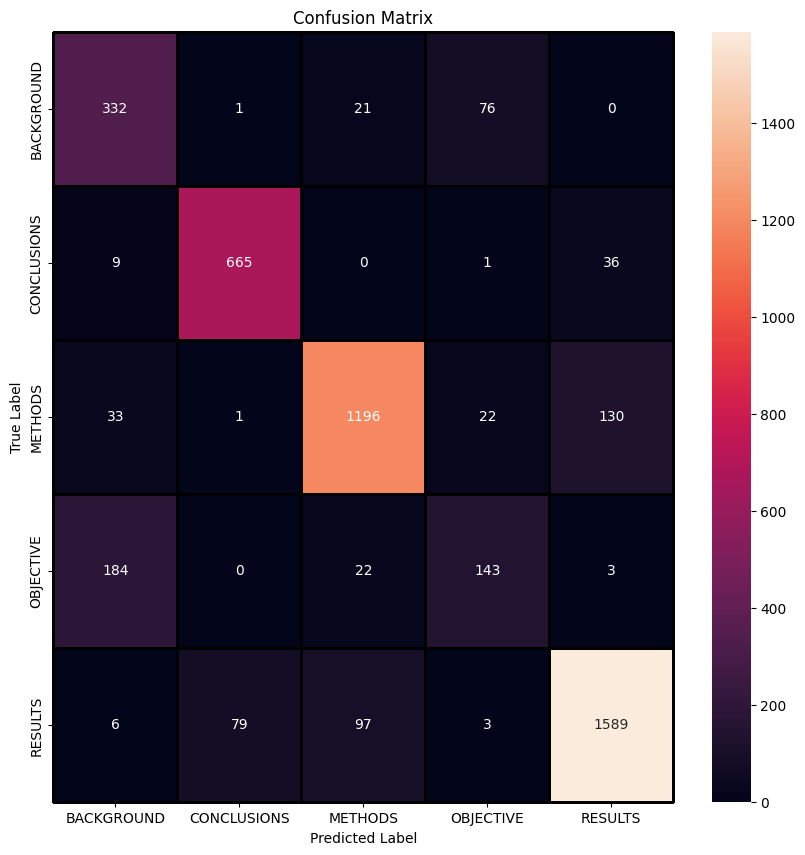

In [85]:
# View Confusion Matrix
plot_confusion_matrix(
    test_labels_encoded, 
    test_predictions, 
    figsize=(10, 10), 
    classes=list(class_names))

# Visualizing word embeddings

In [86]:
# word2vec visualization

In [87]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk
nltk.download('stopwords')

from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [88]:
train_df.head()

,abstract_id,line_id,abstract_text,line_number,total_lines,current_line,target
0,16308853,16308853_0_13,Use of blue dye alone as a marker for sentinel...,0,13,0_13,BACKGROUND
1,16308853,16308853_1_13,Use of the isotope adds extra cost and there a...,1,13,1_13,BACKGROUND
2,16308853,16308853_2_13,The two techniques were compared in a randomiz...,2,13,2_13,BACKGROUND
3,16308853,16308853_3_13,Women with early breast cancer ( less than @ c...,3,13,3_13,METHODS
4,16308853,16308853_4_13,Women older than @ years with multicentric can...,4,13,4_13,METHODS


only one sentence?

In [89]:
STOP_WORDS = nltk.corpus.stopwords.words()

def clean_sentence(val):
    "remove chars that are not letters or numbers, downcase, then remove stop words"
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', val).lower()
    sentence = sentence.split(" ")
    
    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word)  
            
    sentence = " ".join(sentence)
    return sentence

def clean_dataframe(data):
    "drop nans, then apply 'clean_sentence' function to question1 and 2"
    data = data.dropna(how="any")
    
    for col in ['abstract_text']:
        data[col] = data[col].apply(clean_sentence)
    
    return data

data = clean_dataframe(train_df)
data.head(5)

,abstract_id,line_id,abstract_text,line_number,total_lines,current_line,target
0,16308853,16308853_0_13,blue dye marker sentinel lymph node sln biop...,0,13,0_13,BACKGROUND
1,16308853,16308853_1_13,isotope adds extra cost potential radiation ha...,1,13,1_13,BACKGROUND
2,16308853,16308853_2_13,techniques compared randomized trial,2,13,2_13,BACKGROUND
3,16308853,16308853_3_13,women early breast cancer cm palpable axill...,3,13,3_13,METHODS
4,16308853,16308853_4_13,women older years multicentric cancers previo...,4,13,4_13,METHODS


~7mins

In [90]:
data["abstract_text"][0]

'blue dye marker sentinel lymph node  sln  biopsy effective  combining isotope marking improve success rate '

In [91]:
train_df["abstract_text"][0]

'Use of blue dye alone as a marker for sentinel lymph node ( SLN ) biopsy is effective , but combining it with isotope marking can improve the success rate .'

In [92]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['abstract_text']:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
            
    return corpus

corpus = build_corpus(data)        
corpus[0:2]

[['blue',
  'dye',
  'marker',
  'sentinel',
  'lymph',
  'node',
  '',
  'sln',
  '',
  'biopsy',
  'effective',
  '',
  'combining',
  'isotope',
  'marking',
  'improve',
  'success',
  'rate',
  ''],
 ['isotope', 'adds', 'extra', 'cost', 'potential', 'radiation', 'hazards', '']]

In [93]:
model = word2vec.Word2Vec(corpus, window=20, min_count=200, workers=4)
model.wv['cancer']

array([-0.5501139 ,  0.8006123 ,  0.46527424,  0.0462607 ,  0.7135533 ,
       -0.778877  ,  0.32708475,  0.7433035 ,  0.99025416, -0.14555544,
        1.654756  ,  1.0659697 , -0.32368726, -1.4347477 ,  0.46784583,
        0.06996707,  0.00609736, -1.4075732 , -0.53330964,  0.05125189,
       -0.50717735,  0.0337405 ,  0.68945813,  0.83124477, -1.8422954 ,
        1.1598935 , -0.19211271,  0.28964967,  0.36511838,  0.06992085,
       -0.29239547,  1.2101296 , -1.6120172 ,  0.958472  ,  0.68851596,
       -0.03781641, -0.49621865, -0.09364774, -1.478594  ,  0.83241665,
        1.0235072 , -0.5125392 ,  1.1558324 , -1.2398077 , -0.731443  ,
        0.85000914,  0.46971977, -1.6882533 , -0.95044875, -1.5495132 ,
        0.8022058 , -0.7271367 , -0.5861092 , -1.1841128 , -1.1556487 ,
        0.14381641, -0.9131783 ,  1.6809974 ,  0.20986058, -0.44740036,
       -0.39101276,  0.3072814 ,  0.87140346, -0.31018263,  0.17330968,
       -1.0746859 ,  0.26852366,  1.2261976 , -0.08217472,  0.05

In [94]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.key_to_index: # no longer .vocab
        # tokens.append(model[word])
        tokens.append(model.wv.get_vector(word))
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(np.array(tokens))

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

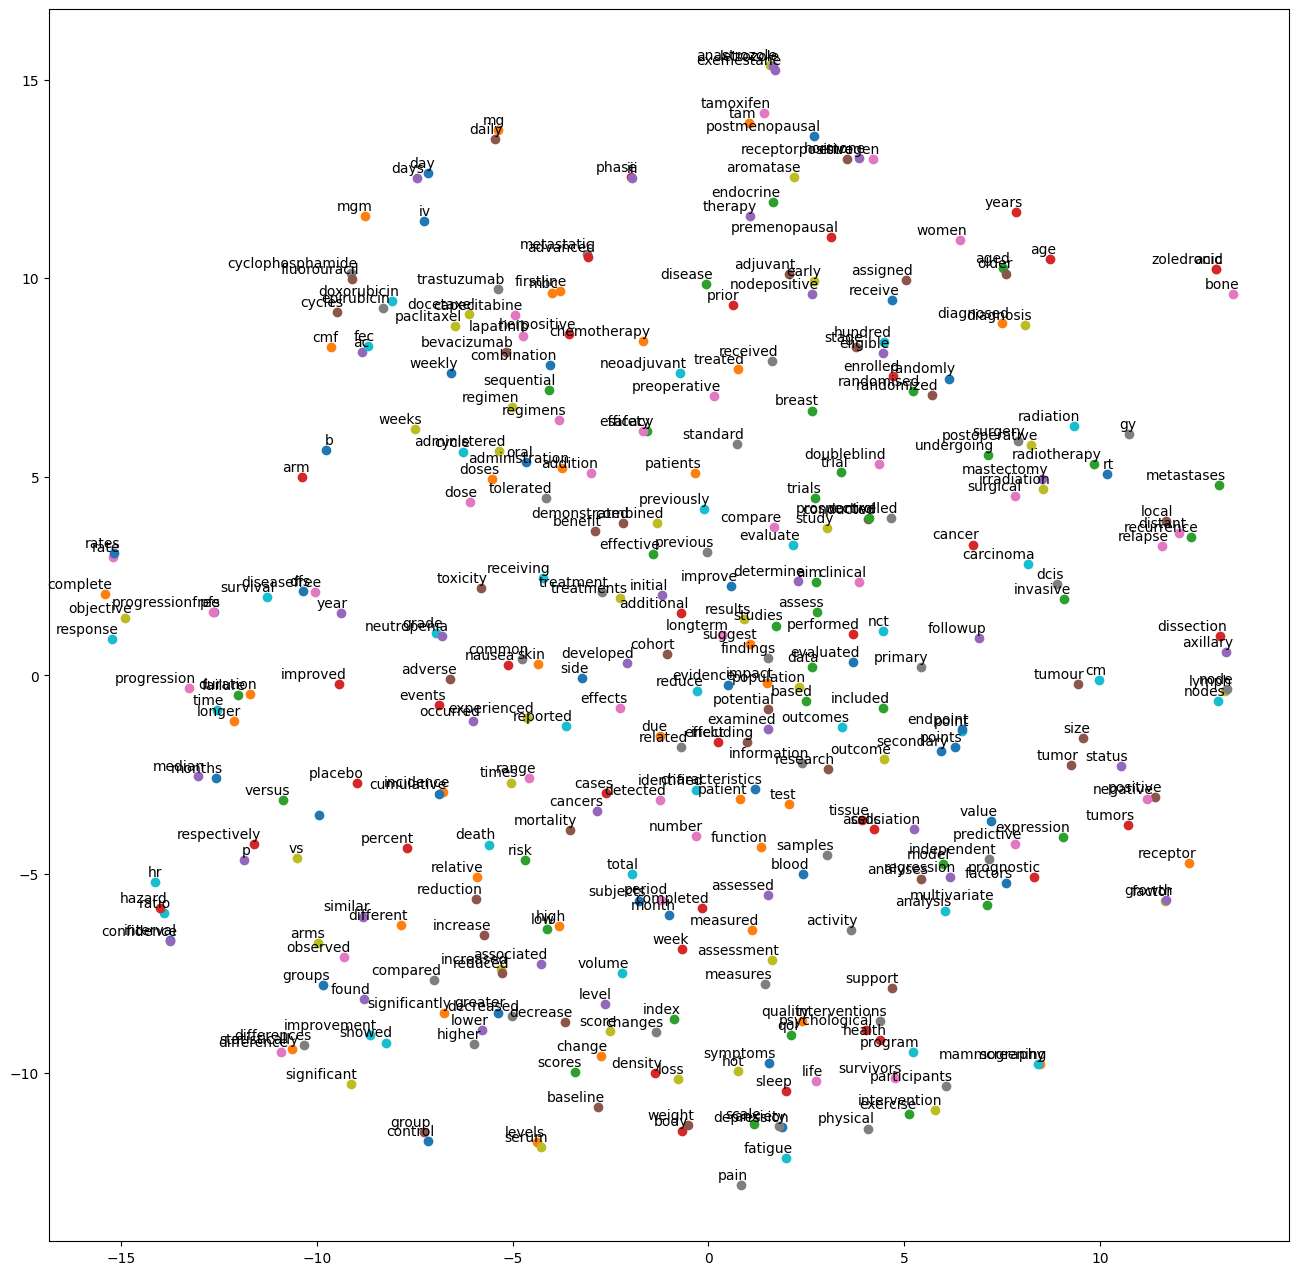

In [95]:
tsne_plot(model)

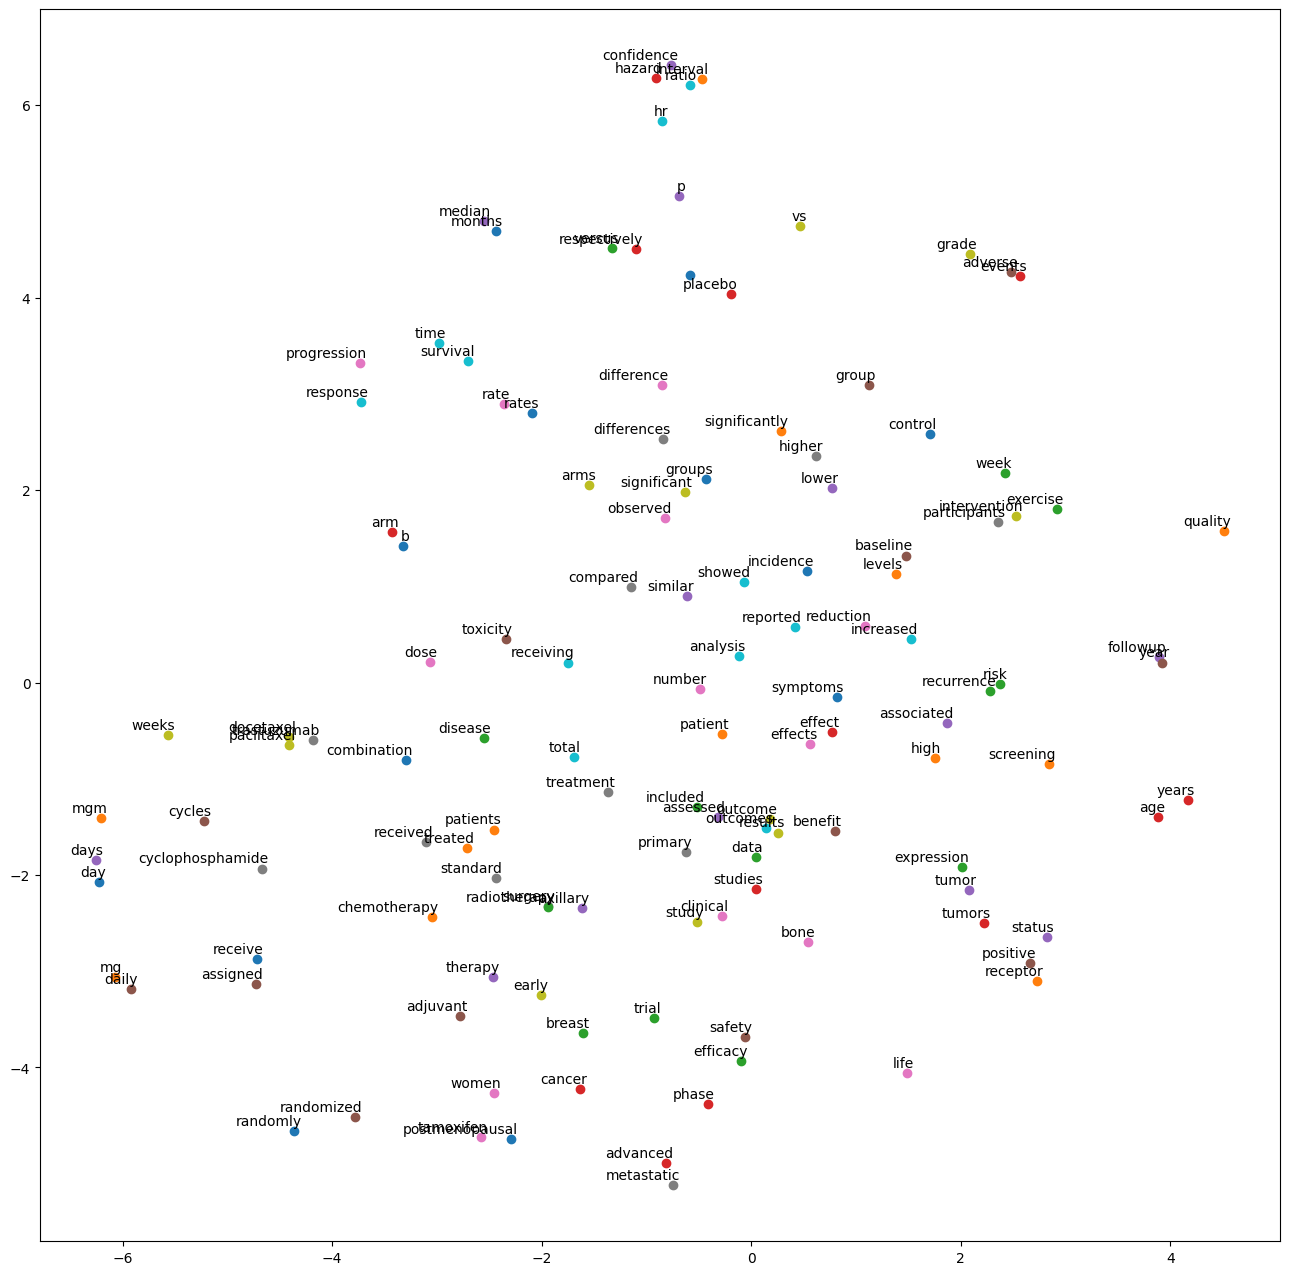

In [96]:
# more selective
model = word2vec.Word2Vec(corpus, vector_size=100, window=20, min_count=500, workers=4)
tsne_plot(model)

## Easier to read

In [97]:
model.wv.most_similar('cancer')

[('postmenopausal', 0.5703584551811218),
 ('early', 0.5317290425300598),
 ('therapy', 0.521954357624054),
 ('adjuvant', 0.47550973296165466),
 ('advanced', 0.46924924850463867),
 ('trial', 0.45884379744529724),
 ('randomized', 0.447314590215683),
 ('studies', 0.445412278175354),
 ('women', 0.4417722821235657),
 ('phase', 0.4304923713207245)]

# To do:
1. Try without numbers replaced with @
2. Try bio word2vec
3. Change encoder
4. Try regularization